In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

from langchain_ollama import OllamaLLM

from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool

from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
# Optional LangSmith tracking
if os.getenv("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

In [3]:
# LANGSMITH_TRACING="true"
# LANGSMITH_API_KEY="..."
# LANGSMITH_PROJECT="default" 

In [4]:
# 1) Initialize model
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:latest")

In [5]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage],add_messages]

In [6]:
# Another way to initialize model
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="llama3.2:latest", model_provider="ollama")

In [ ]:
## Graph with tool call
from langchain_core.tools import tool

@tool
def add(a:float,b:float)->float:
    """ __summary__
    add two numbers
    """
    return a+b

tools = [add]

tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)

# def call_llm_model(state:State):
#     return{"messages":[llm_with_tools].invoke(state["messages"])}

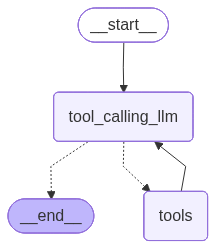

In [22]:
# Creating state graph

from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination

def call_llm_model(state: State):
    return {
        "messages": llm_with_tools.invoke(state["messages"])
    }


## Creating graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

## Adding edges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## Compiling the graph and viweing

graph = builder.compile()

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
response = graph.invoke({"messages":["what is machine learning"]})

In [24]:
response

{'messages': [HumanMessage(content='what is machine learning', additional_kwargs={}, response_metadata={}, id='158367a0-c947-45aa-8973-47847d9f962b'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T19:22:34.6889772Z', 'done': True, 'done_reason': 'stop', 'total_duration': 8262195600, 'load_duration': 6210270500, 'prompt_eval_count': 162, 'prompt_eval_duration': 938629300, 'eval_count': 22, 'eval_duration': 988240200, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4ca9-aa49-7321-a482-1db484b7975e-0', tool_calls=[{'name': 'add', 'args': {'a': '0', 'b': '1'}, 'id': '2afcfc66-a702-41aa-adbc-516733a10d90', 'type': 'tool_call'}], usage_metadata={'input_tokens': 162, 'output_tokens': 22, 'total_tokens': 184}),
  ToolMessage(content='1.0', name='add', id='70a4cb83-3a00-4d52-aa67-fa487ca53cc1', tool_call_id='2afcfc66-a702-41aa-adbc-516733a10d90'),
  AIMessage(content="Machine